<a href="https://colab.research.google.com/github/Stacy067/Deep-learning-and-Tensorflow/blob/main/TF_Certificate_3_%EC%9D%B4%EB%AF%B8%EC%A7%80_%EB%B6%84%EB%A5%98_horses_or_humans_(%EC%8B%A4%EC%8A%B5)%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Category 3

Convolution Neural Network (합성곱 신경망)를 활용한 이미지 분류 (Image Classification)

## 확인

1. GPU 옵션 켜져 있는지 확인할 것!!! (수정 - 노트설정 - 하드웨어설정 (GPU))

## 순서

1. **import**: 필요한 모듈 import
2. **전처리**: 학습에 필요한 데이터 전처리를 수행합니다.
3. **모델링(model)**: 모델을 정의합니다.
4. **컴파일(compile)**: 모델을 생성합니다.
5. **학습 (fit)**: 모델을 학습시킵니다.

## 문제

This task requires you to create a classifier for horses or humans using
the provided dataset. 

Please make sure your final layer is a **1 neuron, activated by sigmoid** as shown.

Please note that the test will use images that are **300x300 with 3 bytes color** depth so be sure to design your neural network accordingly

-------------------------------

이 작업에서는 다음을 사용하여 말이나 사람을위한 분류기를 만들어야합니다.

최종 레이어에 **sigmoid에 의해 활성화 된 1 개의 뉴런**이 있는지 확인하십시오

중요 : 테스트에는 **300x300 크기의 이미지**가 사용됩니다.
3 바이트 색상 심도이므로 입력 레이어를 수용하도록 설계하십시오

-----------------------------------


# 실습

## STEP 1. import 

**[코드]**

In [1]:
import urllib.request
import zipfile
import numpy as np
from IPython.display import Image

# 필요한 모듈을 import 합니다.

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint

## STEP 1. Load Dataset

말과 사람을 구분하는 **이진 분류 (Binary Classification)** 문제입니다.

In [2]:
_TRAIN_URL = "https://storage.googleapis.com/download.tensorflow.org/data/horse-or-human.zip"
_TEST_URL = "https://storage.googleapis.com/download.tensorflow.org/data/validation-horse-or-human.zip"

urllib.request.urlretrieve(_TRAIN_URL, 'horse-or-human.zip')

local_zip = 'horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/horse-or-human/')
zip_ref.close()

urllib.request.urlretrieve(_TEST_URL, 'validation-horse-or-human.zip')
local_zip = 'validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/validation-horse-or-human/')
zip_ref.close()

**데이터 셋 시각화**

Found 1027 images belonging to 2 classes.
(128, 300, 300, 3) (128, 2)
[1. 0.]


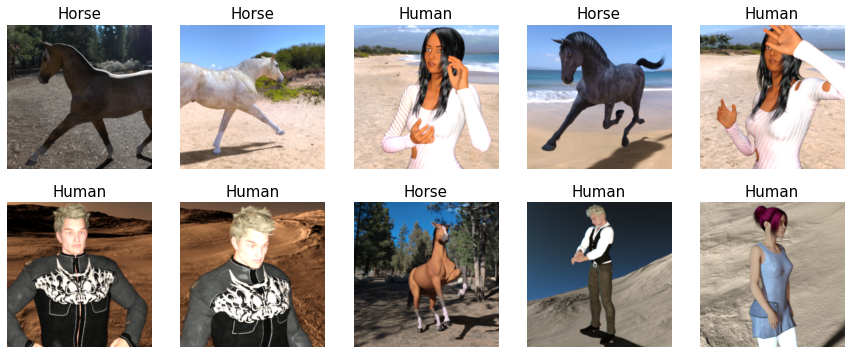

In [3]:
import matplotlib.pyplot as plt

class_map = {
    0: 'Horse',
    1: 'Human', 
}

original_datagen = ImageDataGenerator(rescale=1./255)
original_generator = original_datagen.flow_from_directory('tmp/horse-or-human/', 
                                                          batch_size=128, 
                                                          target_size=(300, 300), 
                                                          class_mode='categorical'
                                                         )

for x, y in original_generator:
    print(x.shape, y.shape)
    print(y[0])
    
    fig, axes = plt.subplots(2, 5)
    fig.set_size_inches(15, 6)
    for i in range(10):
        axes[i//5, i%5].imshow(x[i])
        axes[i//5, i%5].set_title(class_map[y[i].argmax()], fontsize=15)
        axes[i//5, i%5].axis('off')
    break
plt.show()

## STEP 2. 전처리 (ImageDataGenerator)

데이터셋의 경로를 지정해 주세요 (root 폴더의 경로를 지정하여야 합니다.)


**[코드]**

In [4]:
TRAINING_DIR = "tmp/horse-or-human/"
VALIDATION_DIR = "tmp/validation-horse-or-human"

`ImageDataGenerator`를 정의합니다.

다음의 옵션 값들로 Image Aumentation(이미지 변형) 옵션을 적절히 조절해 주세요

* `rescale`: 이미지의 픽셀 값을 조정
* `rotation_range`: 이미지 회전
* `width_shift_range`: 가로 방향으로 이동
* `height_shift_range`: 세로 방향으로 이동
* `shear_range`: 이미지 굴절
* `zoom_range`: 이미지 확대
* `horizontal_flip`: 횡 방향으로 이미지 반전
* `fill_mode`: 이미지를 이동이나 굴절시켰을 때 빈 픽셀 값에 대하여 값을 채우는 방식
* `validation_split`: validation set의 구성 비율

**[코드]**

In [5]:
training_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )

**참고** validation의 ImageDataGenerator는 `rescale=1/255`외 다른 옵션은 적용하지 않습니다.

In [6]:
validation_datagen = ImageDataGenerator(rescale=1./ 255)

ImageDataGenerator를 잘 만들어 주었다면, `flow_from_directory`로 이미지를 어떻게 공급해 줄 것인가를 지정해 주어야합니다.

* train / validation set 전용 generator를 별도로 정의합니다.
* `batch_size`를 정의합니다.
* `target_size`를 정의합니다. (300 x 300). 이미지를 알아서 타겟 사이즈 만큼 잘라내어 공급합니다.
* `class_mode`는 출력층의 **activation**이 `softmax`인 경우 'categorical', `sigmoid`인 경우 'binary'를 지정합니다.

**training_generator**에 대한 `flow_from_directory`를 정의합니다.

**[코드]**

In [7]:
train_generator = training_datagen.flow_from_directory(TRAINING_DIR,
                                                       batch_size = 32,
                                                       target_size = (300, 300),
                                                       class_mode = 'binary'
                                                       )

Found 1027 images belonging to 2 classes.


**validation_generator**에 대한 `flow_from_directory`를 정의합니다.


**[코드]**

In [8]:
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              target_size = (300, 300),
                                                              class_mode = 'binary'
                                                              )

Found 256 images belonging to 2 classes.


## STEP 3. 모델 정의 (Sequential)

**[코드]**

In [17]:
model = Sequential([
    Conv2D(64, (3, 3), activation = 'relu', input_shape=(300, 300, 3)),
    MaxPooling2D(2, 2), 
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(1, activation = 'sigmoid')
])

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 298, 298, 64)      1792      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 149, 149, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 147, 147, 64)      36928     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 73, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 71, 71, 64)        36928     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 35, 35, 64)      

## STEP 4. 컴파일 (compile)

1. `optimizer`는 가장 최적화가 잘되는 알고리즘인 'adam'을 사용합니다.
2. `loss`는 무엇을 지정하면 좋을까요?
3. `metrics`를 'acc' 혹은 'accuracy'로 지정하면, 학습시 정확도를 모니터링 할 수 있습니다.

**[코드]**

In [19]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

## STEP 5. ModelCheckpoint

`val_loss` 기준으로 epoch 마다 최적의 모델을 저장하기 위하여, ModelCheckpoint를 만듭니다.
* `checkpoint_path`는 모델이 저장될 파일 명을 설정합니다.
* `ModelCheckpoint`을 선언하고, 적절한 옵션 값을 지정합니다.

**[코드]**

In [20]:
checkpoint_path = "shkim_checkpoint.ckpt"
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             save_weights_only=True,
                             save_best_only=True,
                             monitor='val_loss',
                             verbose=1)

## STEP 6. 학습 (fit)

**[코드]**

In [21]:
model.fit(train_generator,
          validation_data=(validation_generator),
          epochs=20,
          callbacks=[checkpoint],
          )

Epoch 1/20
33/33 [==============================] - ETA: 0s - loss: 0.6498 - acc: 0.6280
Epoch 1: val_loss improved from inf to 1.28403, saving model to shkim_checkpoint.ckpt
33/33 [==============================] - 30s 787ms/step - loss: 0.6498 - acc: 0.6280 - val_loss: 1.2840 - val_acc: 0.5000
Epoch 2/20
33/33 [==============================] - ETA: 0s - loss: 0.4962 - acc: 0.7585
Epoch 2: val_loss did not improve from 1.28403
33/33 [==============================] - 26s 783ms/step - loss: 0.4962 - acc: 0.7585 - val_loss: 3.0250 - val_acc: 0.5039
Epoch 3/20
33/33 [==============================] - ETA: 0s - loss: 0.4579 - acc: 0.7799
Epoch 3: val_loss did not improve from 1.28403
33/33 [==============================] - 26s 773ms/step - loss: 0.4579 - acc: 0.7799 - val_loss: 2.1076 - val_acc: 0.6133
Epoch 4/20
33/33 [==============================] - ETA: 0s - loss: 0.3451 - acc: 0.8423
Epoch 4: val_loss did not improve from 1.28403
33/33 [==============================] - 25s 750ms/

## STEP 7. 학습 완료 후 Load Weights (ModelCheckpoint)

학습이 완료된 후에는 반드시 `load_weights`를 해주어야 합니다.

그렇지 않으면, 열심히 ModelCheckpoint를 만든 의미가 없습니다.

**[코드]**

In [22]:
# checkpoint 를 저장한 파일명을 입력합니다.
model.load_weights(checkpoint_path)